## 511 Exploratory Data Analysis

### This notebook explores the filtered dataset of 20717 511 construction events between 2016 and 2019. This EDA was used to select features for the clusteirng process.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
#To create this datafile, run the the 511 Notebooks 00 through 04.
df_511_lion_crash_filtered = pd.read_csv('../data/cleaned_data/511_crash_lion_processed_0630.csv')
print(df_511_lion_crash_filtered.shape)
df_511_lion_crash_filtered.head(2)

NameError: name 'pd' is not defined

In [12]:
print(f'The total number of crashes occuring in proximity to a work zone {df_511_lion_crash_filtered.crash_count_900ft.sum()}')

The total number of crashes occuring in proximity to a work zone 3727


In [24]:
no = df_511_lion_crash_filtered[df_511_lion_crash_filtered.crash_count_900ft != 0]['crash_count_900ft'].shape[0]
pct = df_511_lion_crash_filtered[df_511_lion_crash_filtered.crash_count_900ft != 0]['crash_count_900ft'].shape[0]\
                                                                                / df_511_lion_crash_filtered.shape[0]
print(f'{pct*100:.2f}% of work zones witnessed a crash within 900ft radius')
print(f'{no} work zones witnessed a crash within 900ft radius')

one_crash = df_511_lion_crash_filtered[df_511_lion_crash_filtered.crash_count_900ft == 1]['crash_count_900ft'].shape[0]\
            / df_511_lion_crash_filtered[df_511_lion_crash_filtered.crash_count_900ft != 0].shape[0]
two_crash = df_511_lion_crash_filtered[df_511_lion_crash_filtered.crash_count_900ft == 2]['crash_count_900ft'].shape[0]\
            / df_511_lion_crash_filtered[df_511_lion_crash_filtered.crash_count_900ft != 0].shape[0]
print(f'\n{one_crash*100:.2f}% of work zones with a crash witnessed only one')
print(f'{one_crash*100 + two_crash*100:.2f}% of work zones with a crash witnessed only two or less')


14.50% of work zones witnessed a crash within 900ft radius
3005 work zones witnessed a crash within 900ft radius

81.50% of work zones with a crash witnessed only one
96.07% of work zones with a crash witnessed only two or less


#### Performing the EDA on Final Processed data

In [5]:
# Adding Off-peak duration
df_511_lion_crash_filtered['offpeak_duration'] = df_511_lion_crash_filtered.duration - df_511_lion_crash_filtered.peak_duration

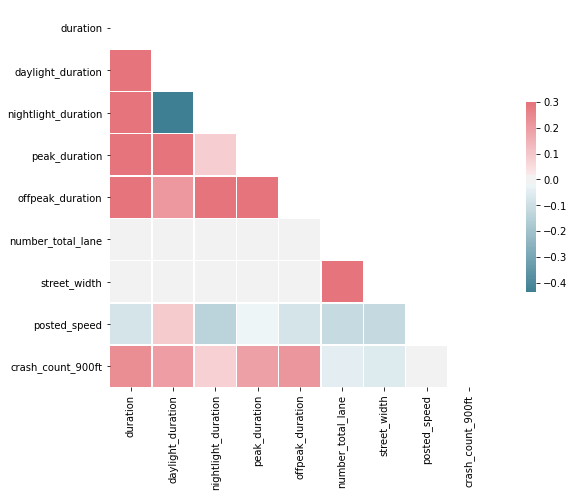

In [6]:
# Analyzing the correlation between different Numerical features
# Compute the correlation matrix
corr = df_511_lion_crash_filtered[['duration', 'daylight_duration', 'nightlight_duration',
                         'peak_duration', 'offpeak_duration',
                         'number_total_lane', 'street_width', "posted_speed",
                         'crash_count_900ft']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [21]:
df_511_lion_crash_filtered.number_total_lane.value_counts()

3.0    9237
4.0    4510
2.0    4424
1.0    1770
6.0     492
5.0     255
7.0      26
8.0       3
Name: number_total_lane, dtype: int64

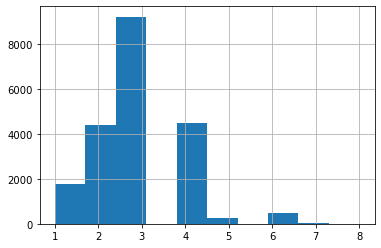

In [26]:
df_511_lion_crash_filtered.number_total_lane.hist()

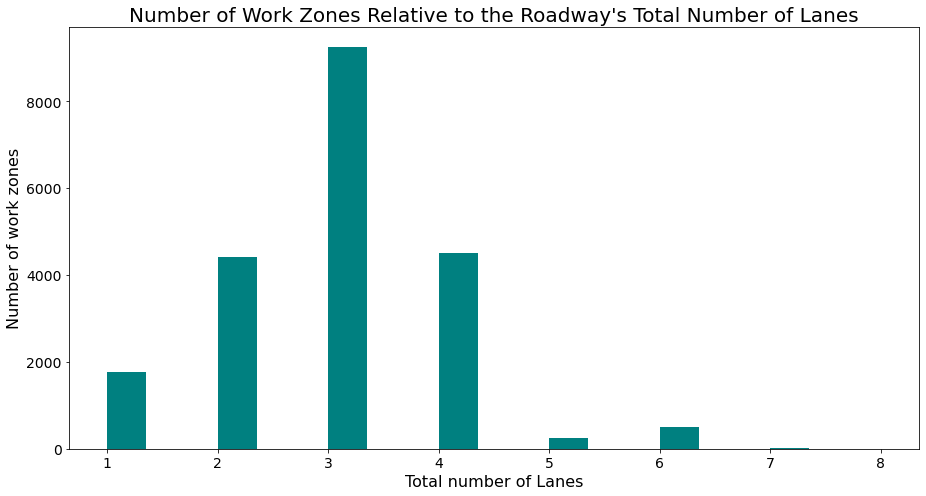

In [64]:
df_511_lion_crash_filtered.number_total_lane.hist(figsize=(13,7), grid=False, bins='auto', color='teal', width=.35)
plt.xlabel('Total number of Lanes', fontsize=16)
plt.ylabel('Number of work zones', fontsize=16)
plt.xticks(np.arange(1,9), size=14)
plt.yticks(size=14)
plt.title('Number of Work Zones Relative to the Roadway\'s Total Number of Lanes', fontsize=20)
plt.tight_layout()

In [16]:
df_511_lion_crash_filtered.duration.mean()

5.181790317130859

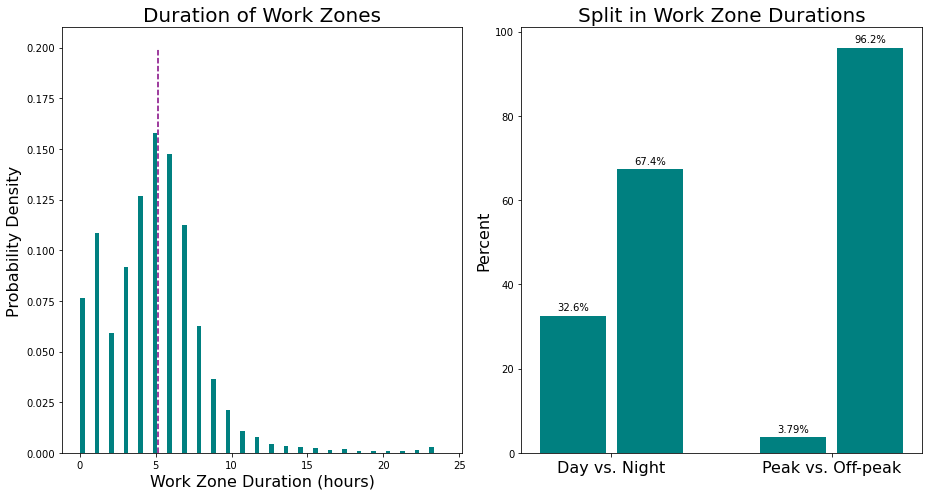

In [73]:
fig, (ax1,ax2) = plt.subplots(1,2)
df_511_lion_crash_filtered.duration.hist(figsize=(13,7), density=True, bins=25, grid=False, color='teal', width=.3, ax=ax1)
mean = df_511_lion_crash_filtered.duration.mean()
ax1.vlines(mean, 0, 0.2, color='purple', linestyle='dashed')
ax1.set_xlabel('Work Zone Duration (hours)', fontsize=16)
ax1.set_ylabel('Probability Density', fontsize=16)
ax1.set_title('Duration of Work Zones', fontsize=20)
plt.tight_layout()

peak_pct = df_511_lion_crash_filtered.peak_duration.sum() / df_511_lion_crash_filtered.duration.sum() *100
day_pct = df_511_lion_crash_filtered.daylight_duration.sum() / df_511_lion_crash_filtered.duration.sum()*100

labels=['Day vs. Night', 'Peak vs. Off-peak']
day = [day_pct, peak_pct]
peak = [100-day_pct, 100-peak_pct]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax2.bar(x - width/2, day, .3, color='teal')
rects2 = ax2.bar(x + width/2, peak, .3, color='teal')

ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=16)
ax2.set_ylabel('Percent', fontsize=16)
ax2.set_title('Split in Work Zone Durations', fontsize=20)
# plt.tight_layout()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax2.annotate('{:.3}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

In [75]:
print(peak_pct)
print(day_pct)

3.793003925280105
32.60329923495618


In [76]:
t = df_511_lion_crash_filtered.groupby('day_of_week').agg({'event_id': 'count', 'crash_count_900ft': 'sum'})
t.columns = ['number_work_zones', 'number_crashes_900ft']
xticks=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
t = t.reindex(xticks)
t

,number_work_zones,number_crashes_900ft
day_of_week,,
Monday,3262,529
Tuesday,3894,658
Wednesday,4023,698
Thursday,3847,695
Friday,3615,789
Saturday,1407,258
Sunday,669,100


In [77]:
df = df_511_lion_crash_filtered.groupby('season').agg({'event_id': 'count', 'crash_count_900ft': 'sum'})
df.columns = ['number_work_zones', 'number_crashes_900ft']
df = df.reindex(['winter', 'spring', 'summer', 'fall'])
df

,number_work_zones,number_crashes_900ft
season,,
winter,5728,786
spring,3402,713
summer,8513,1592
fall,3074,636


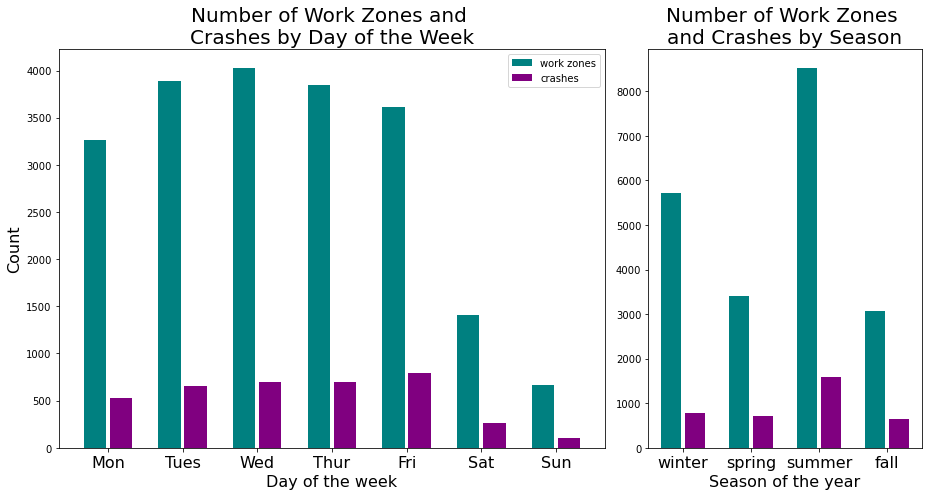

In [78]:
# fig, (ax1,ax2) = plt.subplots(1,2, )
from matplotlib import gridspec

fig = plt.figure(figsize=(13,7))
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[2, 1])
ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])

labels = ['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax1.bar(x - width/2, t.number_work_zones, .3, color='teal', label='work zones')
rects2 = ax1.bar(x + width/2, t.number_crashes_900ft, .3, color='purple', label='crashes')


ax1.set_title('Number of Work Zones and \nCrashes by Day of the Week', fontsize=20)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=16)
ax1.set_xlabel('Day of the week', fontsize=16)
ax1.set_ylabel('Count', fontsize=16)
ax1.legend()
plt.tight_layout()

labels = df.index
x = np.arange(len(labels))  # the label locations
rects3 = ax2.bar(x - width/2, df.number_work_zones, .3, color='teal', label='work zones')
rects4 = ax2.bar(x + width/2, df.number_crashes_900ft, .3, color='purple', label='crashes')
ax2.set_title('Number of Work Zones \nand Crashes by Season', fontsize=20)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=16)
ax2.set_xlabel('Season of the year', fontsize=16)
# ax2.set_ylabel('Count', fontsize=16)
# ax2.legend()
plt.tight_layout()

In [13]:
t['crash_prop'] = 100.0 * t.number_crashes_900ft/t.number_work_zones

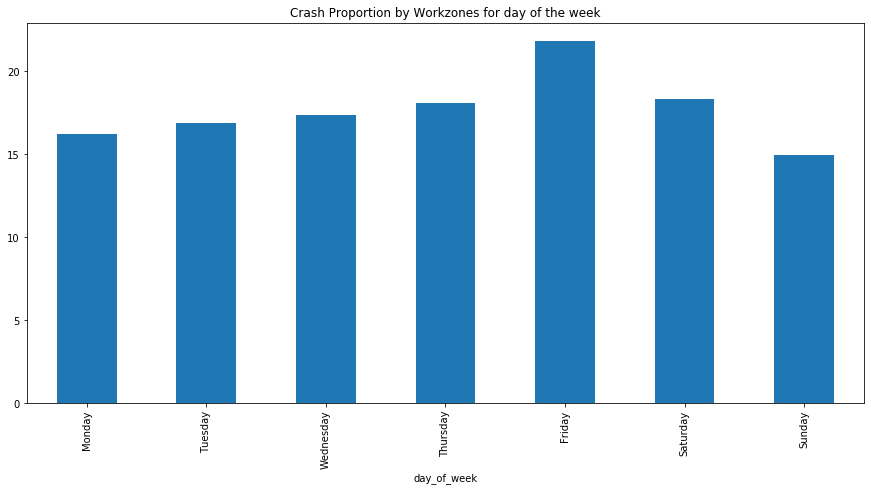

In [14]:
t.reindex(xticks).crash_prop.plot(kind="bar",title="Crash Proportion by Workzones for day of the week", figsize=(15,7) )
# t.title("Crash Proportion by Workzones")

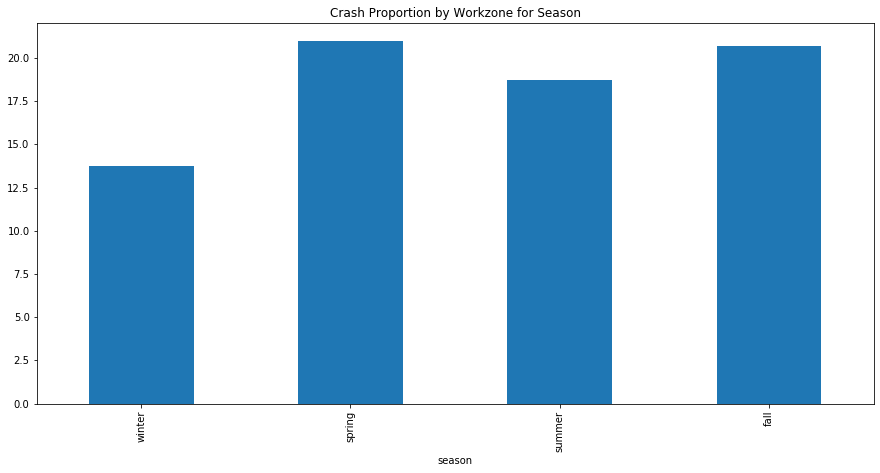

In [15]:
df['crash_prop'] = 100.0 * df.number_crashes_900ft/df.number_work_zones
df.crash_prop.plot(kind="bar", figsize=(15,7), title="Crash Proportion by Workzone for Season" )